In [ ]:
# Import Statements
import os
import logging
import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision.transforms import CenterCrop
import matplotlib.pyplot as plt
import numpy as np

In [93]:
# Lets define some parameters
IMAGE_FOLDER = ['..\TestData', '..\TestData2']
LOG_FILE = '..\log.txt'
HISTORY_FILE = '..\loss_history.npy'
MODEL_FOLDER = '..\Models'

IMAGE_SIZE = 444
MASK_RADIUS = 120
TEST_SPLIT = .15
VALIDATION_SPLIT = .15
BATCH_SIZE = 32
EPOCHS = 1000
LEARNING_RATE = 5e-6
FLAG_NOTEBOOK = True
CPU_IN_NOTEBOOK = True

In [94]:
logging.basicConfig(filename=LOG_FILE, encoding='utf-8', filemode='w', level=logging.DEBUG, format='%(asctime)s > %(levelname)s : %(message)s')
logging.info('FermiUN started!')

In [95]:
# Lets write our custom datasets, dataloaders and related functions first
class FermiUNDataset(Dataset):
    def __init__(self, image_dirs, transform=None, target_transform=None):
        self.image_dirs = image_dirs
        self.image_list = []
        for folder in image_dirs:
            _elements = os.listdir(folder)
            _elements = [os.path.join(folder, el) for el in _elements]
            self.image_list += _elements
        self.transform = transform
        self.target_transform = target_transform

        # Make the mask for our images
        _scale = np.arange(IMAGE_SIZE)
        _mask = np.zeros((IMAGE_SIZE, IMAGE_SIZE))
        _mask[(_scale[np.newaxis, :] - (IMAGE_SIZE - 1) / 2) ** 2
             + (_scale[:, np.newaxis] - (IMAGE_SIZE - 1) / 2) ** 2
             > MASK_RADIUS ** 2] = 1
        self.mask = torch.from_numpy(_mask)

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, index):
        _image = np.load(self.image_list[index])
        _image = _image[np.newaxis, ...]
        _image = torch.from_numpy(_image)
        _masked = _image * self.mask
        _target = CenterCrop([2*MASK_RADIUS, 2*MASK_RADIUS])(_image)
        if self.transform:
            _masked = self.transform(_masked)
        if self.target_transform:
            _target = self.target_transform(_target)
        return _masked, _target


FermiUNData = FermiUNDataset(IMAGE_FOLDER)

# Split into training, validation, test
dataset_size = len(FermiUNData)
dataset_indices = list(range(dataset_size))
np.random.seed(42)
np.random.shuffle(dataset_indices)
first_split, second_split = int(np.floor(VALIDATION_SPLIT*dataset_size)), \
                            dataset_size-int(np.floor(TEST_SPLIT*dataset_size))
validation_indices, train_indices, test_indices = dataset_indices[:first_split], \
                                                  dataset_indices[first_split:second_split], \
                                                  dataset_indices[second_split:]

FermiUNLoaderTraining = DataLoader(FermiUNData, batch_size=BATCH_SIZE,
                                   sampler=SubsetRandomSampler(train_indices))
FermiUNLoaderValidation = DataLoader(FermiUNData, batch_size=BATCH_SIZE,
                                     sampler=SubsetRandomSampler(validation_indices))
FermiUNLoaderTesting = DataLoader(FermiUNData, batch_size=BATCH_SIZE,
                                  sampler=SubsetRandomSampler(test_indices))

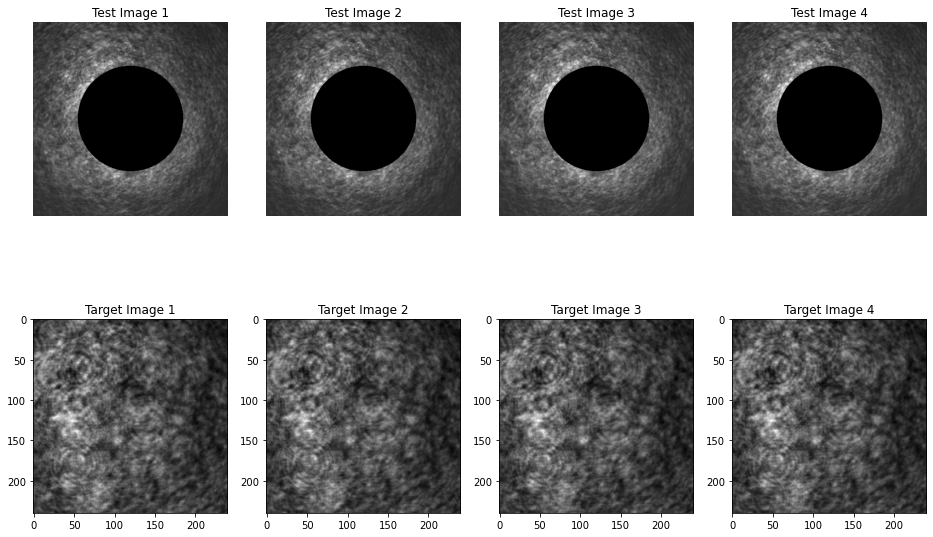

In [96]:
# Test our Dataloader
if FLAG_NOTEBOOK:
    figure = plt.figure(figsize=(16,10))
    test_image,target_image = next(iter(FermiUNLoaderTesting))
    for i in range(1,5):
        figure.add_subplot(2, 4, i)
        plt.title(f'Test Image {i}')
        plt.axis('off')
        plt.imshow(test_image[i, 0, :, :], cmap="gray")
        figure.add_subplot(2, 4, i+4)
        plt.title(f'Target Image {i}')#    plt.axis('off')
        plt.imshow(target_image[i, 0, :, :], cmap="gray")
    plt.show()

In [97]:
# Do we have a gpu?
if FLAG_NOTEBOOK:
    device = "cpu"
    print(f"Using {device} device!")
else:
    if not torch.cuda.is_available() or (FLAG_NOTEBOOK and CPU_IN_NOTEBOOK):
        device = "cpu"
        logging.warning("Cuda device unavailable, using cpu!")
    else:
        device = "cuda"
        logging.info("Using cuda device!")

Using cpu device!


In [98]:
# Lets define our model
class EncoderBlock(nn.Module):
    def __init__(self, channels_in, channels_out):
        super().__init__()
        self.conv1 = nn.Conv2d(channels_in, channels_out, 3)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(channels_out, channels_out, 3)

    def forward(self, x):
        return self.relu(self.conv2(self.relu(self.conv1(x))))


class Encoder(nn.Module):
    def __init__(self, channels=(1, 16, 32, 64, 128, 256)):
        super().__init__()
        self.EncoderBlocks = nn.ModuleList(
            [EncoderBlock(channels[i], channels[i+1])
             for i in range(len(channels)-1)])
        self.MaxPool = nn.MaxPool2d(2)

    def forward(self, x):
        outputs = []
        for block in self.EncoderBlocks:
            x = block(x)
            outputs.append(x)
            x = self.MaxPool(x)
        return outputs


class Decoder(nn.Module):
    def __init__(self, channels=(256, 128, 64, 32, 16)):
        super().__init__()
        self.channels = channels
        self.UpConvolutions = nn.ModuleList(
            [nn.ConvTranspose2d(channels[i], channels[i+1], 2, 2)
             for i in range(len(channels)-1)])
        self.DecoderBlocks = nn.ModuleList(
            [EncoderBlock(channels[i], channels[i+1])
             for i in range(len(channels)-1)])

    def crop(self, encoder_features, x):
        # crop the encoder features to match the current dimensions
        _,_,height,width = x.shape
        encoder_features = CenterCrop([height, width])(encoder_features)
        return encoder_features

    def forward(self, x, encoder_features):
        for i in range(len(self.channels)-1):
            x = self.UpConvolutions[i](x)
            cropped_feature = self.crop(encoder_features[i], x)
            x = torch.cat([x, cropped_feature], dim=1)
            x = self.DecoderBlocks[i](x)
        return x


class Head(nn.Module):
    def __init__(self, height, width, channels):
        super().__init__()
        self.height = height
        self.width = width
        self.head = nn.Conv2d(channels, 1, 1)

    def forward(self, x):
        x = self.head(x)
        x = CenterCrop([self.height, self.width])(x)
        return x


class Unet(nn.Module):
    def __init__(self, encoder_channels=(1, 16, 32, 64, 128, 256), decoder_channels=(256, 128, 64, 32, 16)):
        super().__init__()
        self.flatten = nn.Flatten()
        self.encoder = Encoder(encoder_channels)
        self.decoder = Decoder(decoder_channels)
        self.head = Head(2*MASK_RADIUS, 2*MASK_RADIUS, decoder_channels[-1])

    def forward(self, x):
        encoder_features = self.encoder(x)
        decoder_features = self.decoder(encoder_features[::-1][0], encoder_features[::-1][1:])
        out = self.head(decoder_features)
        return out


model = Unet().to(device)
if FLAG_NOTEBOOK:
    print(model)

Unet(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (encoder): Encoder(
    (EncoderBlocks): ModuleList(
      (0): EncoderBlock(
        (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
        (relu): ReLU()
        (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
      )
      (1): EncoderBlock(
        (conv1): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
        (relu): ReLU()
        (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
      )
      (2): EncoderBlock(
        (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
        (relu): ReLU()
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
      )
      (3): EncoderBlock(
        (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
        (relu): ReLU()
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
      )
      (4): EncoderBlock(
        (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
        (relu): ReLU()
        (conv2

In [99]:
# Test the encoder and decoder definitions
if FLAG_NOTEBOOK:
    encoder = Encoder()#
    x = torch.randn(1, 1, 444, 444)
    ftrs = encoder(x)
    for ftr in ftrs: print(ftr.shape)

    decoder = Decoder()
    x = decoder(ftrs[::-1][0], ftrs[::-1][1:])

    head = Head(2*MASK_RADIUS, 2*MASK_RADIUS, 16)
    y = head(x)
    print(y.shape)

torch.Size([1, 16, 440, 440])
torch.Size([1, 32, 216, 216])
torch.Size([1, 64, 104, 104])
torch.Size([1, 128, 48, 48])
torch.Size([1, 256, 20, 20])
torch.Size([1, 1, 240, 240])


In [100]:
# Training Loops
def training_loop(dataloader, model, loss_function, optimizer):
    avg_loss, batches = 0, 0
    for batch, (X,y) in enumerate(dataloader):
        X, y = X.float().to(device), y.float().to(device)
        prediction = model(X)
        loss = loss_function(prediction, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch*len(X)
            if FLAG_NOTEBOOK:
                print(f"Loss: {loss:>7f} [{current:>5d}/{len(dataloader.dataset):>5d}]")
            else:
                logging.info(f"Loss: {loss:>7f} [{current:>5d}/{len(dataloader.dataset):>5d}]")
        avg_loss += loss
        batches +=1
    return avg_loss/batches


def no_inference_loop(dataloader, model, loss_function):
    num_batches = len(dataloader)
    loss = 0

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.float().to(device), y.float().to(device)
            prediction = model(X)
            loss += loss_function(prediction, y).item()
        loss /= num_batches
    return loss


def test_loop(dataloader, model, loss_function):
    loss = no_inference_loop(dataloader, model, loss_function)
    if FLAG_NOTEBOOK:
        print(f"Average loss in test dataset: {loss:>8f}")
    else:
        logging.info(f"Average loss in test dataset: {loss:>8f}")
    return loss


def validation_loop(dataloader, model, loss_function):
    loss = no_inference_loop(dataloader, model, loss_function)
    if FLAG_NOTEBOOK:
        print(f"Validation loss: {loss:>7f}")
    else:
        logging.info(f"Validation loss: {loss:>7f}")
    return loss



In [101]:
# Train the network
torch.cuda.empty_cache()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

loss_history = np.zeros((EPOCHS,3,))

for epoch in range(EPOCHS):
    if FLAG_NOTEBOOK:
        print(f"Epoch {epoch+1}\n--------------------------")
    else:
        logging.info(f"Epoch {epoch+1}\n--------------------------")
    loss_history[epoch,0] = epoch+1
    loss_history[epoch,1] = training_loop(FermiUNLoaderTraining, model, loss_function, optimizer)
    loss_history[epoch,2] = validation_loop(FermiUNLoaderValidation, model, loss_function)
    np.save(HISTORY_FILE, loss_history)

    if epoch > 1 and epoch % 20 == 0:
        torch.save(model, os.path.join(MODEL_FOLDER, f"Model_e{epoch}.pt"))

test_loop(FermiUNLoaderTesting, model, loss_function)
if EPOCHS % 20 > 0:
    torch.save(model, os.path.join(MODEL_FOLDER, f"FinishedModel.pt"))
logging.info(f"Training complete.")

Epoch 1
--------------------------
Loss: 0.021465 [    0/  201]
Validation loss: 0.021442
Epoch 2
--------------------------
Loss: 0.021362 [    0/  201]


KeyboardInterrupt: 

[[0.02153404 0.02144151]
 [0.         0.        ]
 [0.         0.        ]
 ...
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]]
